In [30]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
from iris.time import PartialDateTime
from iris.util import mask_cube_from_shapefile
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from shapely import MultiPolygon, Polygon

import os
import torch
import pandas as pd
import sklearn
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable 
from torch.utils.data import Dataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [31]:
filenames = ['C:/Users/Tilt/Downloads/Project/Data/data_2010.nc','C:/Users/Tilt/Downloads/Project/Data/data_2011.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2012.nc','C:/Users/Tilt/Downloads/Project/Data/data_2013.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2014.nc','C:/Users/Tilt/Downloads/Project/Data/data_2015.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2016.nc','C:/Users/Tilt/Downloads/Project/Data/data_2017.nc',
             'C:/Users/Tilt/Downloads/Project/Data/data_2018.nc','C:/Users/Tilt/Downloads/Project/Data/data_2019.nc']
cubes = iris.load(filenames)
cubes = cubes.concatenate()
#print(cubes)

In [32]:
ConstraintNames = [
    'burned_area',
    'population_density',
    '10 metre wind speed',
    '2 metre temperature',
    'Convective available potential energy',
    'Leaf area index, high vegetation',
    'Leaf area index, low vegetation',
    'Total precipitation',
    'Volumetric soil water layer 1',
    'observed_fraction_mask'
]

cubesList = { name: cubes.extract(iris.Constraint(name))[0] for name in ConstraintNames}
print(cubesList)

{'burned_area': <iris 'Cube' of burned_area / (m2) (time: 120; latitude: 720; longitude: 1440)>, 'population_density': <iris 'Cube' of population_density / (unknown) (time: 120; latitude: 720; longitude: 1440)>, '10 metre wind speed': <iris 'Cube' of 10 metre wind speed / (m s**-1) (time: 120; latitude: 720; longitude: 1440)>, '2 metre temperature': <iris 'Cube' of 2 metre temperature / (K) (time: 120; latitude: 720; longitude: 1440)>, 'Convective available potential energy': <iris 'Cube' of Convective available potential energy / (J kg**-1) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, high vegetation': <iris 'Cube' of Leaf area index, high vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Leaf area index, low vegetation': <iris 'Cube' of Leaf area index, low vegetation / (m**2 m**-2) (time: 120; latitude: 720; longitude: 1440)>, 'Total precipitation': <iris 'Cube' of Total precipitation / (m) (time: 120; latitude: 720; longitude: 1440)>, 'Volu

In [33]:
CountryName = "Portugal"

country_shp_reader = shpreader.Reader(
    shpreader.natural_earth(
        resolution="110m", category="cultural", name="admin_0_countries"
    )
)
Country_shp = [
    country.geometry
    for country in country_shp_reader.records()
    if CountryName in country.attributes["NAME_LONG"]
][0]
ObsMaskCube = mask_cube_from_shapefile(cubesList["observed_fraction_mask"], Country_shp)
ObsMaskCube = iris.analysis.maths.log(ObsMaskCube)
ObsMaskCube = iris.analysis.maths.exp(ObsMaskCube)

b=0
a = ObsMaskCube.data
print("Verification - Count should Equal Sum")
print("Count =",ma.count(a))
print("Sum =",np.sum(a))
if(np.round(np.sum(a)) == ma.count(a)):
    b=b+1
print("Verification Mean should = 1")
print("Mean = ",np.mean(a))
if(np.round(np.mean(a)) == 1):
    b=b+1
print("We have",ma.count(a),"Datapoints Per Month")
if(b==2):
    print("All Verified - Continue")
else:
    print("Somethings gone wrong.")

BurnedCube = iris.analysis.maths.multiply(cubesList["burned_area"], ObsMaskCube)
PopnCube = iris.analysis.maths.multiply(cubesList["population_density"], ObsMaskCube)
WindCube = iris.analysis.maths.multiply(cubesList["10 metre wind speed"], ObsMaskCube)
TempCube = iris.analysis.maths.multiply(cubesList["2 metre temperature"], ObsMaskCube)
CAPECube = iris.analysis.maths.multiply(cubesList["Convective available potential energy"], ObsMaskCube)
HVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube = iris.analysis.maths.multiply(cubesList["Total precipitation"], ObsMaskCube)
SoilCube = iris.analysis.maths.multiply(cubesList["Volumetric soil water layer 1"], ObsMaskCube)

c:\Users\Tilt\miniconda3\Lib\site-packages\iris\_shapefiles.py:147: IrisDefaultingWarning: Cube has no coord_system; using default GeogCS lat/lon
  warnings.warn(


(120, 720, 1440)
[0.0 0.0 0.0 ... 0.0 0.0 0.0]
66960
558


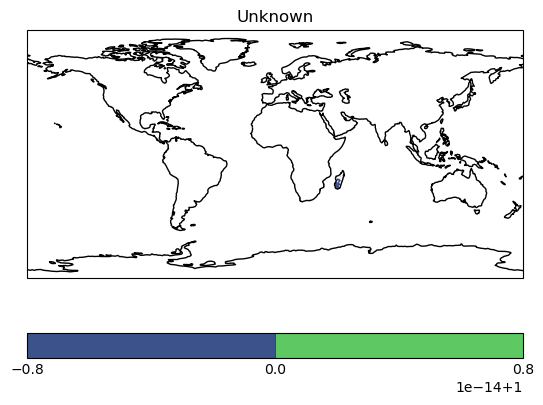

In [5]:
a = BurnedCube.data
print(np.shape(a))
aNoMask = a[~a.mask]
print(aNoMask)
print(len(aNoMask))

aMonth = BurnedCube[0].data
aNoMaskMonth = aMonth[~aMonth.mask]
print(len(aNoMaskMonth))
# 173 Datapoints Per for Portugal
Timesteps = round(len(aNoMask)/len(aNoMaskMonth))
Samples = len(aNoMaskMonth)

qplt.contourf(ObsMaskCube, 25)
plt.gca().coastlines()
plt.show()

In [6]:
def DeCube(InCube):
    InCube = InCube.data
    InCube = InCube[~InCube.mask]
    InCube = InCube.reshape(Timesteps, Samples)
    return InCube

In [7]:
#Verifying this doesnt break it
#a = BurnedCube.data
#a = a[~a.mask]
#print(len(a))

Burned = DeCube(BurnedCube)

Popn = DeCube(PopnCube)
Wind = DeCube(WindCube)
Temp = DeCube(TempCube)
CAPE = DeCube(CAPECube)
HVeg = DeCube(HVegCube)
LVeg = DeCube(LVegCube)
Precip = DeCube(PrecipCube)
Soil = DeCube(SoilCube)

Popn = np.log(Popn)

scaler = StandardScaler()
scaler.fit(Popn)
Popn = scaler.transform(Popn) 
scaler.fit(Wind)
Wind = scaler.transform(Wind) 
scaler.fit(Temp)
Temp = scaler.transform(Temp) 
scaler.fit(CAPE)
CAPE = scaler.transform(CAPE) 
scaler.fit(HVeg)
HVeg = scaler.transform(HVeg) 
scaler.fit(LVeg)
LVeg = scaler.transform(LVeg) 
scaler.fit(Precip)
Precip = scaler.transform(Precip) 
scaler.fit(Soil)
Soil = scaler.transform(Soil) 

X_full = np.dstack((Popn,Wind,Temp,CAPE,HVeg,LVeg,Precip,Soil))
print(X_full.shape)

y_full = Burned

y_full2D = y_full.reshape(120,X_full.shape[1])
y_full2DBinary = y_full2D
y_full2DBinary[y_full2DBinary>0] = 1

print(y_full2D.shape)

X_train = X_full[:-24,:,:]
X_test = X_full[96:,:,:]

y_train = y_full2D[:-24,:]
y_test = y_full2D[96:,:]
print("Training Shape",X_train.shape,y_test.shape)
print("Testing Shape",X_train.shape,y_test.shape)

(120, 558, 8)
(120, 558)
Training Shape (96, 558, 8) (24, 558)
Testing Shape (96, 558, 8) (24, 558)


In [8]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape) 

Training Shape torch.Size([96, 558, 8]) torch.Size([96, 558])
Testing Shape torch.Size([24, 558, 8]) torch.Size([24, 558])


In [9]:
units=1000

In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #Num Classes
        self.num_layers = num_layers #Num Layers
        self.input_size = input_size #Inp Size
        self.hidden_size = hidden_size #Hidden Size
        self.seq_length = seq_length #Seq Length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, units) #fully connected 1
        self.fc_2 =  nn.Linear(units, units) #fully connected 2
        self.fc_3 =  nn.Linear(units, units) #fully connected 3
        self.fc_4 =  nn.Linear(units, units) #fully connected 4
        self.fc = nn.Linear(units, num_classes) #fully connected final layer
        self.relu = nn.ReLU()
        self.Dropout = nn.Dropout(0.2)
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.Dropout(out)
        out = self.fc_2(out) #first Dense
        out = self.relu(out) #relu
        out = self.Dropout(out)
        out = self.fc_3(out) #first Dense
        out = self.relu(out) #relu
        out = self.Dropout(out)
        out = self.fc_4(out) #first Dense
        out = self.relu(out) #relu
        out = self.Dropout(out)
        out = self.fc(out) #Final Output
        return out

In [11]:
num_epochs = 2000 #1000 epochs
learning_rate = 0.00075 #0.001 lr

input_size = 8 #number of features
hidden_size = 25 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = X_full.shape[1] #number of output classes 

In [12]:
lstmClassifier = LSTMClassifier(num_classes, input_size, hidden_size, num_layers, X_train_tensors.shape[1])

In [13]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [14]:
for epoch in range(num_epochs):
  outputs = lstmClassifier.forward(X_train_tensors) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
  loss.backward() #calculates the loss of the loss function
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.29818
Epoch: 100, loss: 0.07472
Epoch: 200, loss: 0.06236
Epoch: 300, loss: 0.04649
Epoch: 400, loss: 0.02843
Epoch: 500, loss: 0.01837
Epoch: 600, loss: 0.01339
Epoch: 700, loss: 0.01090
Epoch: 800, loss: 0.00844
Epoch: 900, loss: 0.00733
Epoch: 1000, loss: 0.00629
Epoch: 1100, loss: 0.00663
Epoch: 1200, loss: 0.00680
Epoch: 1300, loss: 0.00614
Epoch: 1400, loss: 0.00522
Epoch: 1500, loss: 0.00578
Epoch: 1600, loss: 0.00506
Epoch: 1700, loss: 0.00478
Epoch: 1800, loss: 0.00505
Epoch: 1900, loss: 0.00475


(24, 558)


Text(0.5, 1.0, 'Confusion Matrix for LSTM Classifier - Madagascar')

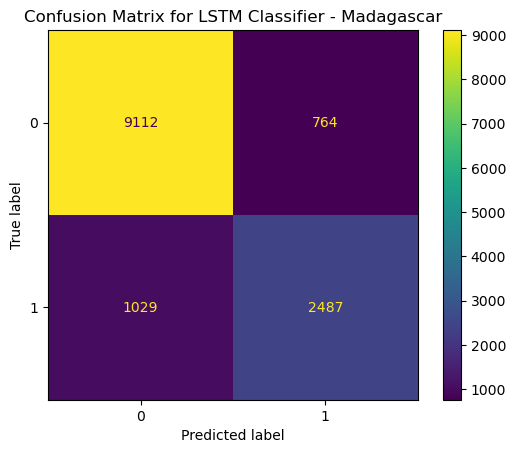

In [15]:
y_pred = lstmClassifier(X_test_tensors)
y_pred = y_pred.data.numpy()
y_pred[y_pred>0.5] = 1
y_pred[y_pred<1] = 0
print(y_pred.shape)
np.savetxt('y_predLSTM.txt', y_pred, fmt='%d')
np.savetxt('y_testLSTM.txt', y_test, fmt='%d')
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test.flatten(), y_pred.flatten())
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix for LSTM Classifier - Madagascar")

In [16]:
#2020
filename2020 = 'C:/Users/Tilt/Downloads/Project/Data/data_2020.nc'
cube2020 = iris.load(filename2020)
cubesList2020 = { name: cube2020.extract(iris.Constraint(name))[0] for name in ConstraintNames}
print(cubesList2020)
BurnedCube2020 = iris.analysis.maths.multiply(cubesList2020["burned_area"], ObsMaskCube)
PopnCube2020 = iris.analysis.maths.multiply(cubesList2020["population_density"], ObsMaskCube)
WindCube2020 = iris.analysis.maths.multiply(cubesList2020["10 metre wind speed"], ObsMaskCube)
TempCube2020 = iris.analysis.maths.multiply(cubesList2020["2 metre temperature"], ObsMaskCube)
CAPECube2020 = iris.analysis.maths.multiply(cubesList2020["Convective available potential energy"], ObsMaskCube)
HVegCube2020 = iris.analysis.maths.multiply(cubesList2020["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube2020 = iris.analysis.maths.multiply(cubesList2020["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube2020 = iris.analysis.maths.multiply(cubesList2020["Total precipitation"], ObsMaskCube)
SoilCube2020 = iris.analysis.maths.multiply(cubesList2020["Volumetric soil water layer 1"], ObsMaskCube)

{'burned_area': <iris 'Cube' of burned_area / (m2) (time: 12; latitude: 720; longitude: 1440)>, 'population_density': <iris 'Cube' of population_density / (unknown) (time: 12; latitude: 720; longitude: 1440)>, '10 metre wind speed': <iris 'Cube' of 10 metre wind speed / (m s**-1) (time: 12; latitude: 720; longitude: 1440)>, '2 metre temperature': <iris 'Cube' of 2 metre temperature / (K) (time: 12; latitude: 720; longitude: 1440)>, 'Convective available potential energy': <iris 'Cube' of Convective available potential energy / (J kg**-1) (time: 12; latitude: 720; longitude: 1440)>, 'Leaf area index, high vegetation': <iris 'Cube' of Leaf area index, high vegetation / (m**2 m**-2) (time: 12; latitude: 720; longitude: 1440)>, 'Leaf area index, low vegetation': <iris 'Cube' of Leaf area index, low vegetation / (m**2 m**-2) (time: 12; latitude: 720; longitude: 1440)>, 'Total precipitation': <iris 'Cube' of Total precipitation / (m) (time: 12; latitude: 720; longitude: 1440)>, 'Volumetric s

In [17]:
def DeCube2020(InCube):
    InCube = InCube.data
    InCube = InCube[~InCube.mask]
    InCube = InCube.reshape(12,Samples)
    return InCube

In [27]:
Burned2020 = DeCube2020(BurnedCube2020)
Popn2020 = DeCube2020(PopnCube2020)
Wind2020 = DeCube2020(WindCube2020)
Temp2020 = DeCube2020(TempCube2020)
CAPE2020 = DeCube2020(CAPECube2020)
HVeg2020 = DeCube2020(HVegCube2020)
LVeg2020 = DeCube2020(LVegCube2020)
Precip2020 = DeCube2020(PrecipCube2020)
Soil2020 = DeCube2020(SoilCube2020)
Popn2020 = np.log(Popn2020)
scaler = MinMaxScaler()
scaler.fit(Popn2020)
Popn2020 = scaler.transform(Popn2020) 
scaler.fit(Wind2020)
Wind2020 = scaler.transform(Wind2020) 
scaler.fit(Temp2020)
Temp2020 = scaler.transform(Temp2020) 
scaler.fit(CAPE2020)
CAPE2020 = scaler.transform(CAPE2020) 
scaler.fit(HVeg2020)
HVeg2020 = scaler.transform(HVeg2020) 
scaler.fit(LVeg2020)
LVeg2020 = scaler.transform(LVeg2020) 
scaler.fit(Precip2020)
Precip2020 = scaler.transform(Precip2020) 
scaler.fit(Soil2020)
Soil2020 = scaler.transform(Soil2020) 

X_full2020 = np.dstack((Popn2020,Wind2020,Temp2020,CAPE2020,HVeg2020,LVeg2020,Precip2020,Soil2020))
print(X_full2020.shape)

y_full2020 = Burned2020
y_full2020 = y_full2020.reshape(12,X_full2020.shape[1],1)
y_full2DBinary2020 = y_full2020
y_full2DBinary2020[y_full2020>0]=1
y_full2DBinary2020[y_full2020==0]=0
X_test_tensors2020 = Variable(torch.Tensor(X_full2020))
y_test_tensors2020 = Variable(torch.Tensor(y_full2DBinary2020)) 

print("Testing Shape 2020", X_test_tensors2020.shape, y_test_tensors2020.shape) 

(12, 558, 8)
Testing Shape 2020 torch.Size([12, 558, 8]) torch.Size([12, 558, 1])


(12, 558)
(12, 558, 1)


Text(0.5, 1.0, 'Confusion Matrix for LSTM Classifier - Madagascar - 2020')

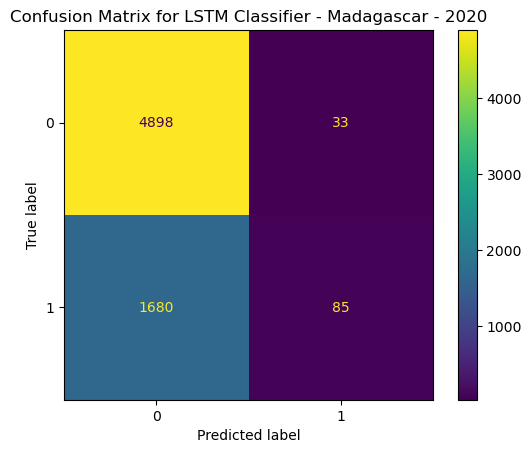

In [29]:
y_pred2020 = lstm1(X_test_tensors2020)
y_pred2020 = y_pred2020.data.numpy()
y_pred2020[y_pred2020>0.5] = 1
y_pred2020[y_pred2020<1] = 0
print(y_pred2020.shape)
print(y_full2DBinary2020.shape)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_full2DBinary2020.flatten(), y_pred2020.flatten())
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix for LSTM Classifier - Madagascar - 2020")

CountryName = "Brazil"
Country_shp = [
    country.geometry
    for country in country_shp_reader.records()
    if CountryName in country.attributes["NAME_LONG"]
][0]
ObsMaskCube = mask_cube_from_shapefile(cubesList["observed_fraction_mask"], Country_shp)
BurnedCube = iris.analysis.maths.multiply(cubesList["burned_area"], ObsMaskCube)

PopnCube = iris.analysis.maths.multiply(cubesList["population_density"], ObsMaskCube)
WindCube = iris.analysis.maths.multiply(cubesList["10 metre wind speed"], ObsMaskCube)
TempCube = iris.analysis.maths.multiply(cubesList["2 metre temperature"], ObsMaskCube)
CAPECube = iris.analysis.maths.multiply(cubesList["Convective available potential energy"], ObsMaskCube)
HVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, high vegetation"], ObsMaskCube)
LVegCube = iris.analysis.maths.multiply(cubesList["Leaf area index, low vegetation"], ObsMaskCube)
PrecipCube = iris.analysis.maths.multiply(cubesList["Total precipitation"], ObsMaskCube)
SoilCube = iris.analysis.maths.multiply(cubesList["Volumetric soil water layer 1"], ObsMaskCube)

BurnedCube = iris.analysis.maths.add(BurnedCube,1)
BurnedCube = iris.analysis.maths.log(BurnedCube)

Burned = DeCube(BurnedCube)

Popn = DeCube(PopnCube)
Wind = DeCube(WindCube)
Temp = DeCube(TempCube)
CAPE = DeCube(CAPECube)
HVeg = DeCube(HVegCube)
LVeg = DeCube(LVegCube)
Precip = DeCube(PrecipCube)
Soil = DeCube(SoilCube)

X_full = np.dstack((Popn,Wind,Temp,CAPE,HVeg,LVeg,Precip,Soil))
y_full = Burned

aMonth = BurnedCube[0].data
aNoMaskMonth = aMonth[~aMonth.mask]
print(len(aNoMaskMonth))

mm = MinMaxScaler()
#ss = StandardScaler()
y_full2D = y_full.reshape(120,len(aNoMaskMonth))
#X_ss = ss.fit_transform(X_full)
y_mm = mm.fit_transform(y_full2D) 

print(y_full2D.shape)

X_train = X_full[:-24,:,:]
X_test = X_full[96:,:,:]

y_train = y_mm[:-24,:]
y_test = y_mm[96:,:]
print("Training Shape",X_train.shape,y_test.shape)
print("Testing Shape",X_train.shape,y_test.shape)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

print("Training Shape", X_train_tensors.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors.shape, y_test_tensors.shape) 